In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10,6)


Cell 2 — Load Dataset

In [6]:
customer_df = pd.read_csv('../data/processed/customer_features_final.csv')

print(f"Total customers: {len(customer_df)}")
print(f"Churn rate: {customer_df['Churn'].mean()*100:.2f}%")

customer_df.head()


Total customers: 4339
Churn rate: 33.39%


,Customer ID,Recency,Frequency,Monetary,Churn,avg_quantity_per_order,max_quantity,min_quantity,std_quantity,total_items_purchased,...,std_order_value,revenue_per_item,active_days,active_months,customer_tenure_days,days_since_first_purchase,purchase_span_days,avg_days_between_orders,order_consistency,spend_consistency
0,12346.0,326,1,1.04,1,74215.000000,74215,74215,0.000000,74215,...,0.000000,0.000014,1,1,0,326,0,0.000000,1.000000,1.040000
1,12347.0,2,7,481.21,0,13.505495,240,2,18.856172,2458,...,2.255381,0.195773,7,7,365,367,365,60.833333,0.019178,0.812197
2,12348.0,75,4,178.71,0,75.516129,144,1,51.091990,2341,...,13.400323,0.076339,4,4,282,358,282,94.000000,0.014184,0.400327
3,12349.0,19,1,605.10,0,8.643836,36,1,6.982856,631,...,35.028021,0.958954,1,1,0,19,0,0.000000,1.000000,0.230072
4,12350.0,310,1,65.30,1,11.588235,24,1,4.345383,197,...,9.334751,0.331472,1,1,0,310,0,0.000000,1.000000,0.371676


### Cell 3 — Churn Distribution Plot

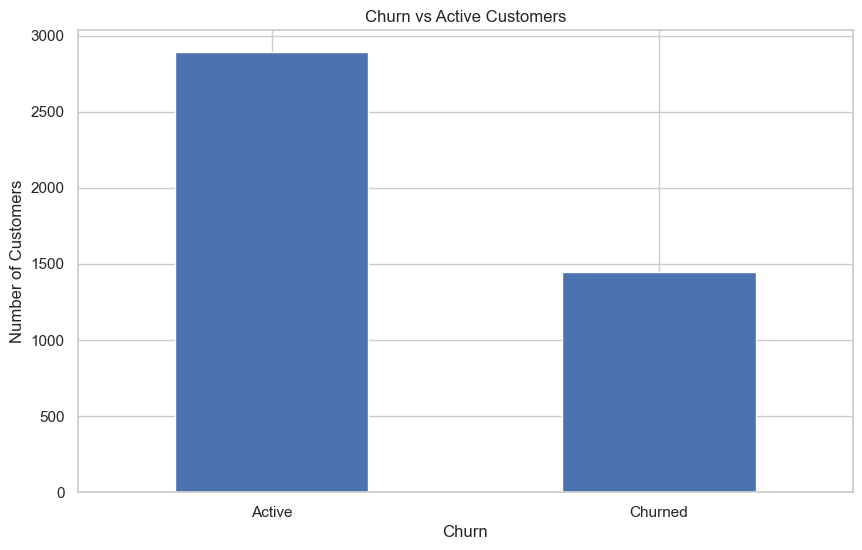

In [11]:
ax = customer_df['Churn'].value_counts().plot(kind='bar')

plt.title("Churn vs Active Customers")
plt.xticks(ticks=[0,1], labels=['Active','Churned'], rotation=0)
plt.ylabel("Number of Customers")

plt.savefig('../visualizations/03_churn_distribution.png', bbox_inches='tight')
plt.show()


In [13]:
def plot_feature(feature, title):
    sns.kdeplot(
        data=customer_df,
        x=feature,
        hue='Churn',
        common_norm=False,
        fill=True
    )
    plt.title(title)
    plt.savefig(f'../visualizations/03_{feature}_distribution.png', bbox_inches='tight')
    plt.show()


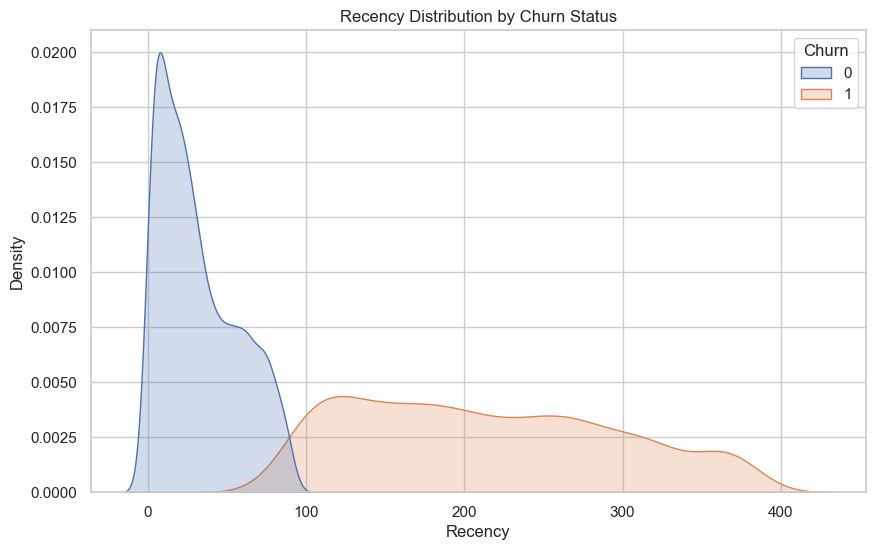

In [15]:
plot_feature('Recency', "Recency Distribution by Churn Status")


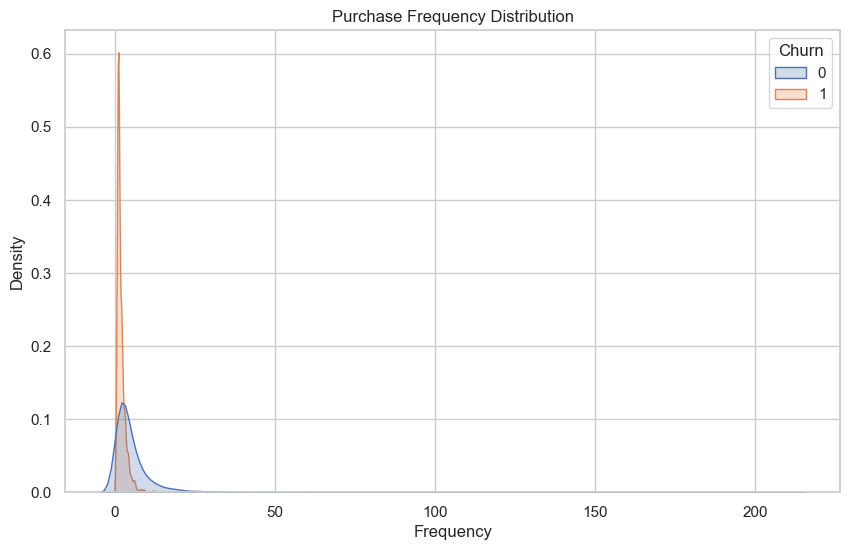

In [17]:
plot_feature('Frequency', "Purchase Frequency Distribution")


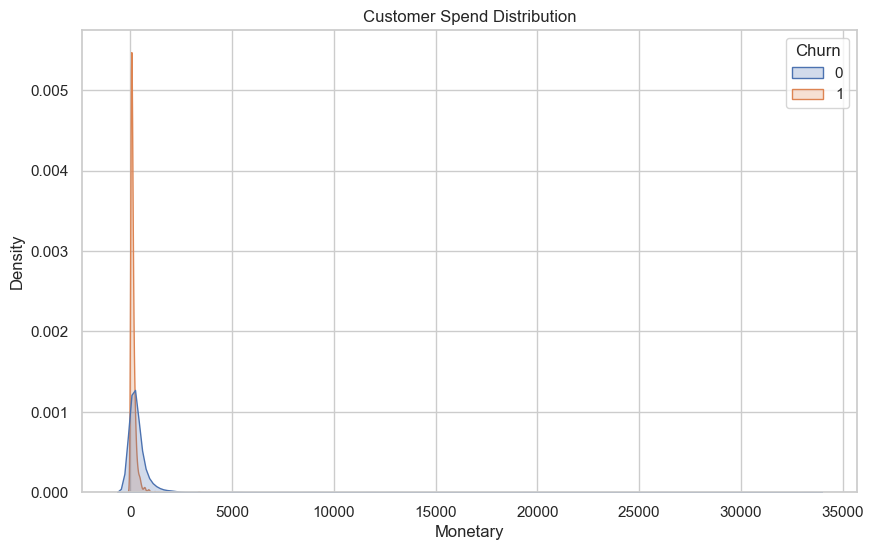

In [19]:
plot_feature('Monetary', "Customer Spend Distribution")


### Cell 8 — Correlation Heatmap

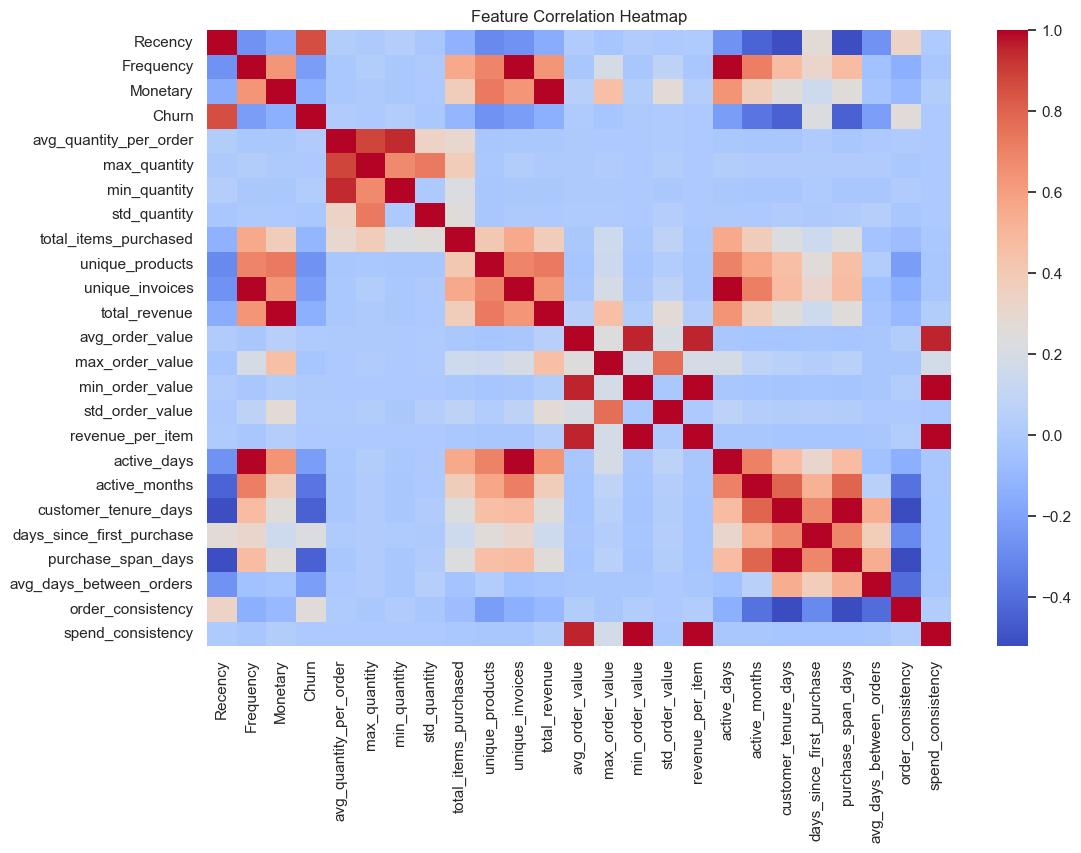

In [25]:
features = customer_df.drop(columns=['Customer ID'])

corr = features.corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")

plt.savefig('../visualizations/03_feature_correlation_heatmap.png', bbox_inches='tight')
plt.show()


In [27]:
corr['Churn'].sort_values(ascending=False)


Churn                        1.000000
Recency                      0.857418
order_consistency            0.259088
days_since_first_purchase    0.224019
min_quantity                 0.022824
avg_quantity_per_order       0.018021
avg_order_value              0.012612
std_order_value              0.012217
min_order_value              0.003210
spend_consistency            0.000107
revenue_per_item            -0.000697
max_quantity                -0.001653
std_quantity                -0.009952
max_order_value             -0.023465
total_items_purchased       -0.107716
total_revenue               -0.136720
Monetary                    -0.136720
avg_days_between_orders     -0.214767
unique_invoices             -0.222058
Frequency                   -0.222058
active_days                 -0.222234
unique_products             -0.267866
active_months               -0.374710
customer_tenure_days        -0.448750
purchase_span_days          -0.448750
Name: Churn, dtype: float64

In [37]:
freq_bins = pd.qcut(
    customer_df['Frequency'],
    q=4,
    duplicates='drop'
)


In [39]:
freq_bins.unique()


[(0.999, 2.0], (5.0, 210.0], (2.0, 5.0]]
Categories (3, interval[float64, right]): [(0.999, 2.0] < (2.0, 5.0] < (5.0, 210.0]]

In [41]:
labels_map = ['Low','Medium','High','Very High']

customer_df['freq_group'] = pd.qcut(
    customer_df['Frequency'],
    q=4,
    duplicates='drop',
    labels=labels_map[:freq_bins.nunique()]
)


C:\Users\DELL\AppData\Local\Temp\ipykernel_1800\1300768853.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_churn = customer_df.groupby('freq_group')['Churn'].mean()


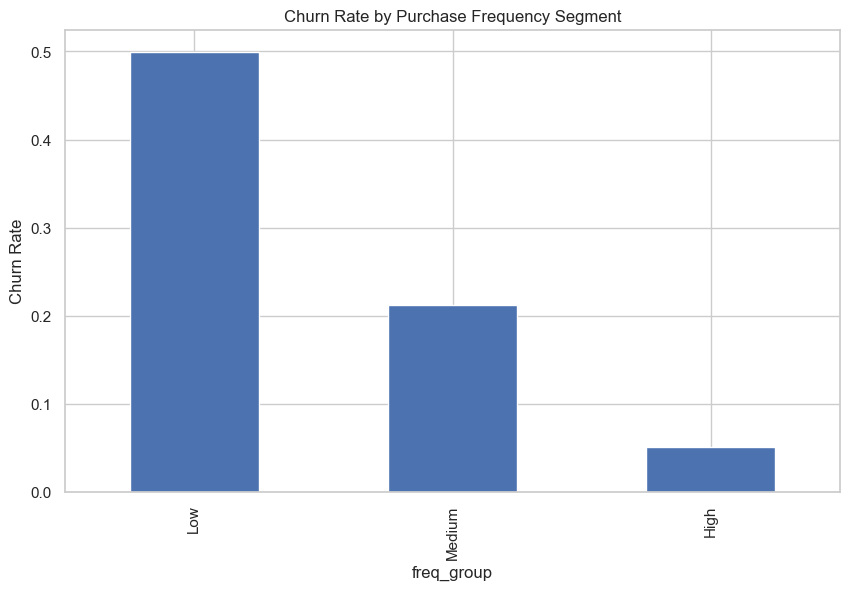

In [43]:
segment_churn = customer_df.groupby('freq_group')['Churn'].mean()

segment_churn.plot(kind='bar')
plt.ylabel("Churn Rate")
plt.title("Churn Rate by Purchase Frequency Segment")
plt.savefig('../visualizations/03_segment_churn.png', bbox_inches='tight')
plt.show()


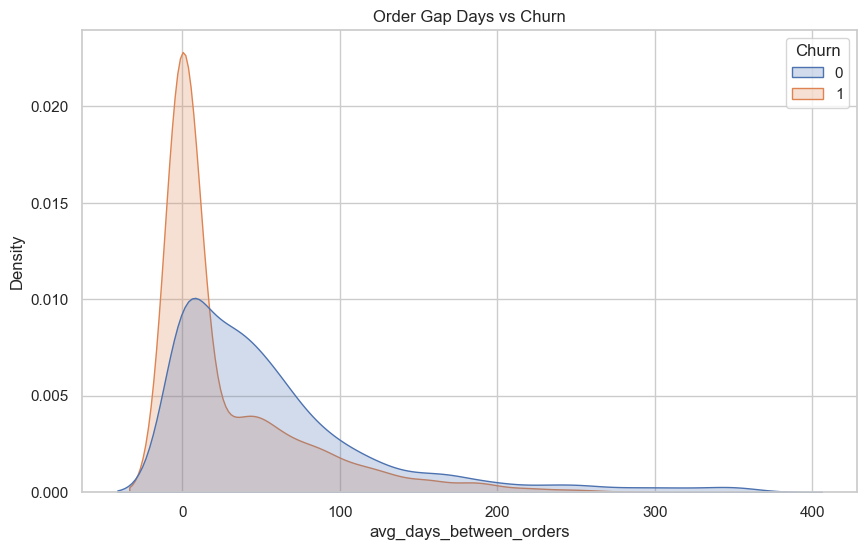

In [45]:
if 'avg_days_between_orders' in customer_df.columns:
    plot_feature('avg_days_between_orders', "Order Gap Days vs Churn")


In [47]:
from scipy import stats

features_to_test = ['Recency','Frequency','Monetary']

results = {}

for f in features_to_test:
    churn = customer_df[customer_df['Churn']==1][f]
    active = customer_df[customer_df['Churn']==0][f]
    
    t_stat, p = stats.ttest_ind(churn, active, equal_var=False)
    
    results[f] = float(p)

results


{'Recency': 0.0,
 'Frequency': 2.139107572177709e-89,
 'Monetary': 1.286878389973367e-35}

In [49]:
for f,p in results.items():
    if p < 0.05:
        print(f"✔ {f}: SIGNIFICANT difference (p={p:.4f})")
    else:
        print(f"✖ {f}: NOT significant (p={p:.4f})")


✔ Recency: SIGNIFICANT difference (p=0.0000)
✔ Frequency: SIGNIFICANT difference (p=0.0000)
✔ Monetary: SIGNIFICANT difference (p=0.0000)


In [51]:
summary = customer_df.groupby('Churn')[['Recency','Frequency','Monetary']].mean()
summary


,Recency,Frequency,Monetary
Churn,,,
0,31.806920,5.483391,367.648371
1,213.605935,1.855763,113.896198


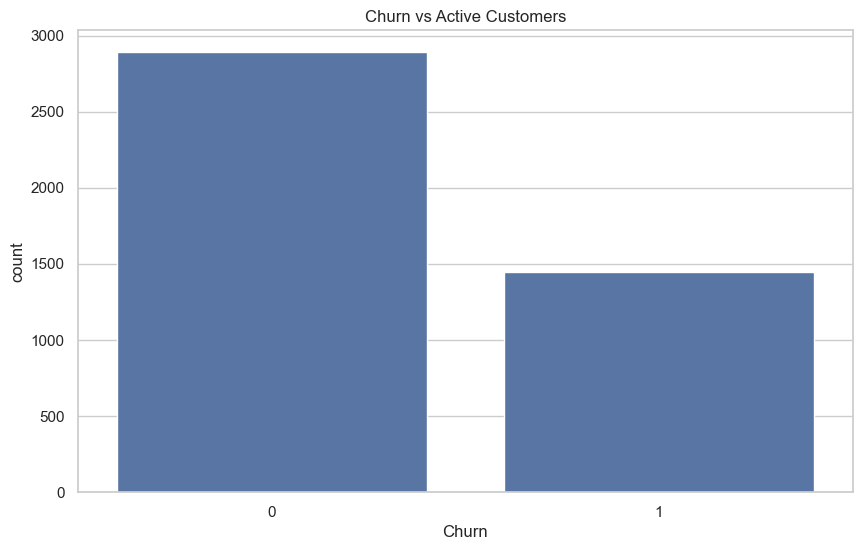

In [53]:
sns.countplot(x='Churn', data=customer_df)
plt.title("Churn vs Active Customers")
plt.savefig('../visualizations/01_churn_distribution.png')
plt.show()


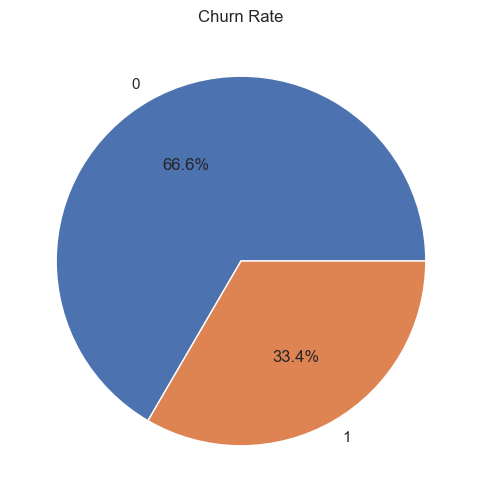

In [55]:
customer_df['Churn'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title("Churn Rate")
plt.ylabel("")
plt.savefig('../visualizations/02_churn_pie.png')
plt.show()


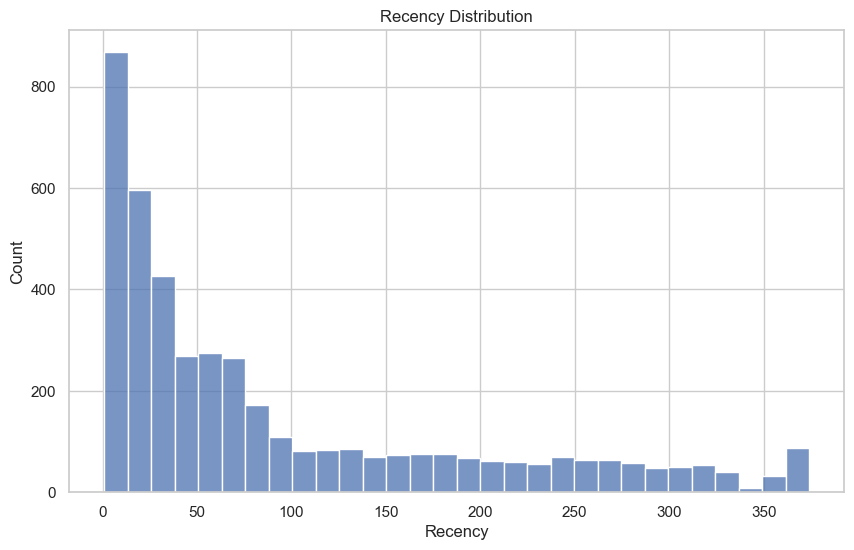

In [57]:
sns.histplot(customer_df['Recency'], bins=30)
plt.title("Recency Distribution")
plt.savefig('../visualizations/03_recency_dist.png')
plt.show()


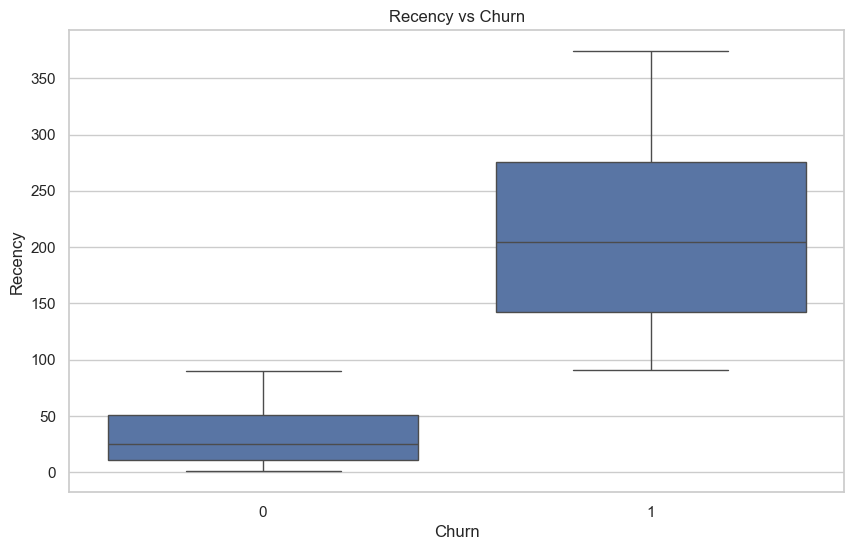

In [59]:
sns.boxplot(x='Churn', y='Recency', data=customer_df)
plt.title("Recency vs Churn")
plt.savefig('../visualizations/04_recency_churn.png')
plt.show()


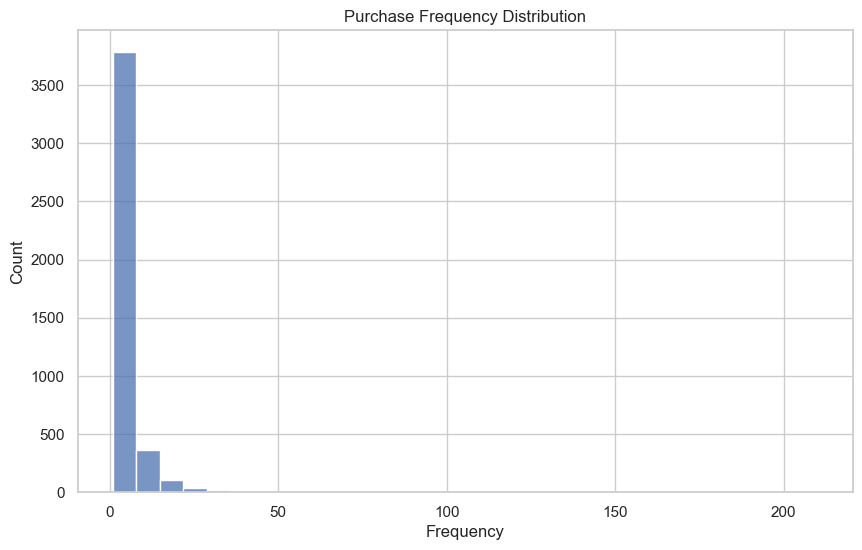

In [61]:
sns.histplot(customer_df['Frequency'], bins=30)
plt.title("Purchase Frequency Distribution")
plt.savefig('../visualizations/05_frequency_dist.png')
plt.show()


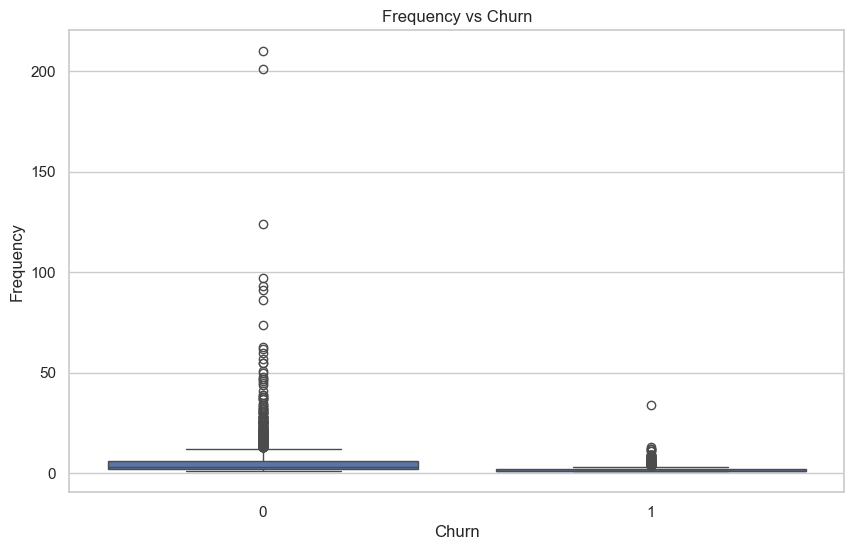

In [63]:
sns.boxplot(x='Churn', y='Frequency', data=customer_df)
plt.title("Frequency vs Churn")
plt.savefig('../visualizations/06_frequency_churn.png')
plt.show()


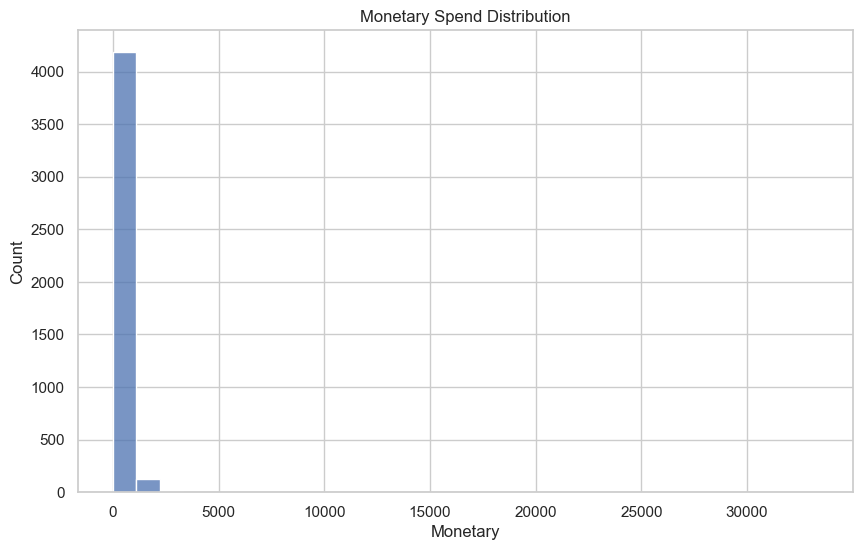

In [65]:
sns.histplot(customer_df['Monetary'], bins=30)
plt.title("Monetary Spend Distribution")
plt.savefig('../visualizations/07_monetary_dist.png')
plt.show()


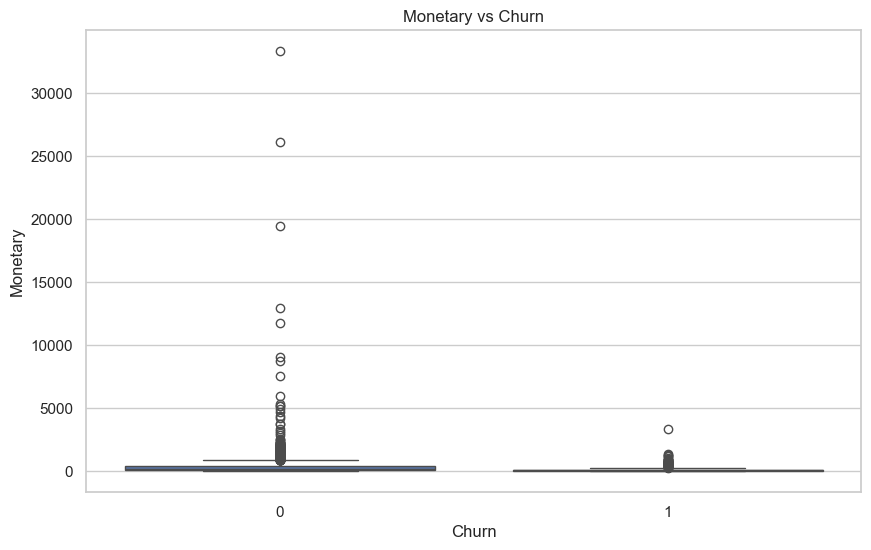

In [67]:
sns.boxplot(x='Churn', y='Monetary', data=customer_df)
plt.title("Monetary vs Churn")
plt.savefig('../visualizations/08_monetary_churn.png')
plt.show()


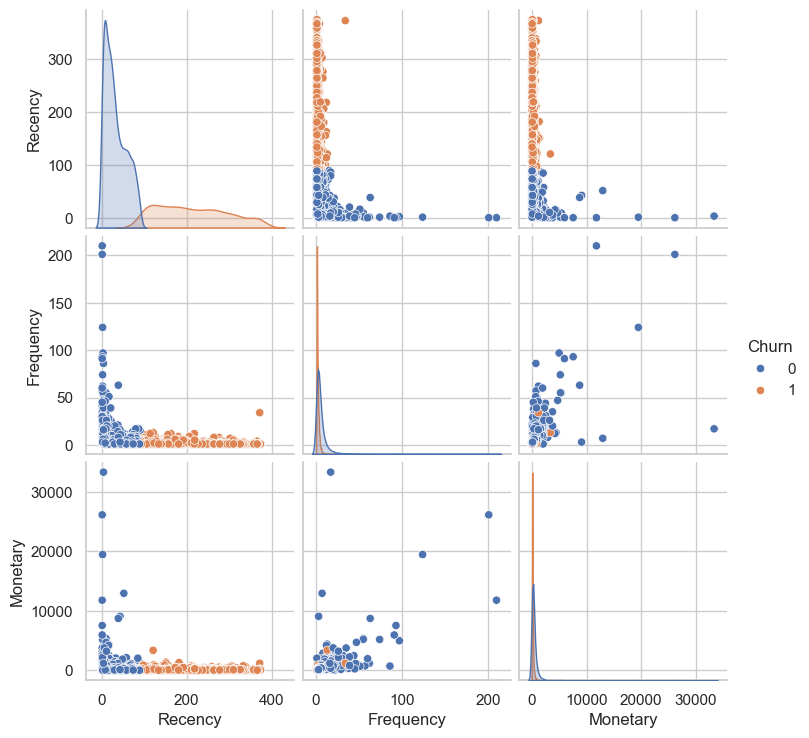

In [71]:
sns.pairplot(customer_df[['Recency','Frequency','Monetary','Churn']], hue='Churn')
plt.savefig('../visualizations/10_feature_pairplot.png')
plt.show()


In [73]:
freq_bins = pd.qcut(customer_df['Frequency'], q=4, duplicates='drop')
labels = ['Low','Medium','High','Very High'][:freq_bins.nunique()]
customer_df['freq_group'] = pd.qcut(customer_df['Frequency'], q=4, duplicates='drop', labels=labels)


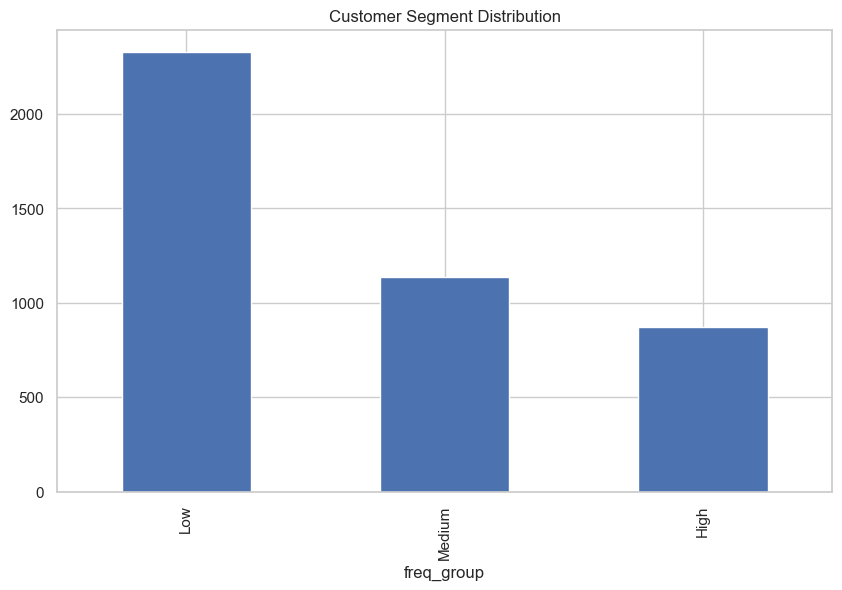

In [75]:
customer_df['freq_group'].value_counts().plot(kind='bar')
plt.title("Customer Segment Distribution")
plt.savefig('../visualizations/11_segment_distribution.png')
plt.show()


C:\Users\DELL\AppData\Local\Temp\ipykernel_1800\2938490474.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_churn = customer_df.groupby('freq_group')['Churn'].mean()


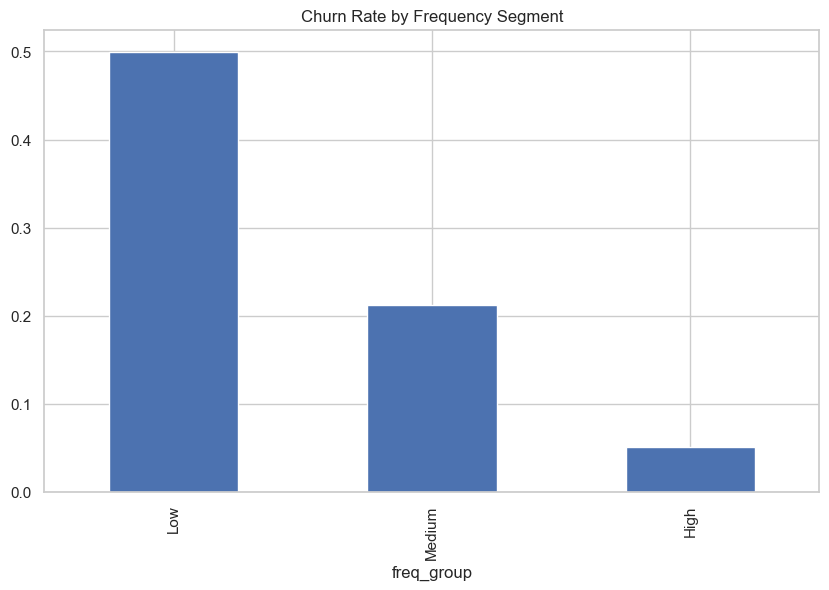

In [77]:
segment_churn = customer_df.groupby('freq_group')['Churn'].mean()
segment_churn.plot(kind='bar')
plt.title("Churn Rate by Frequency Segment")
plt.savefig('../visualizations/12_segment_churn_rate.png')
plt.show()


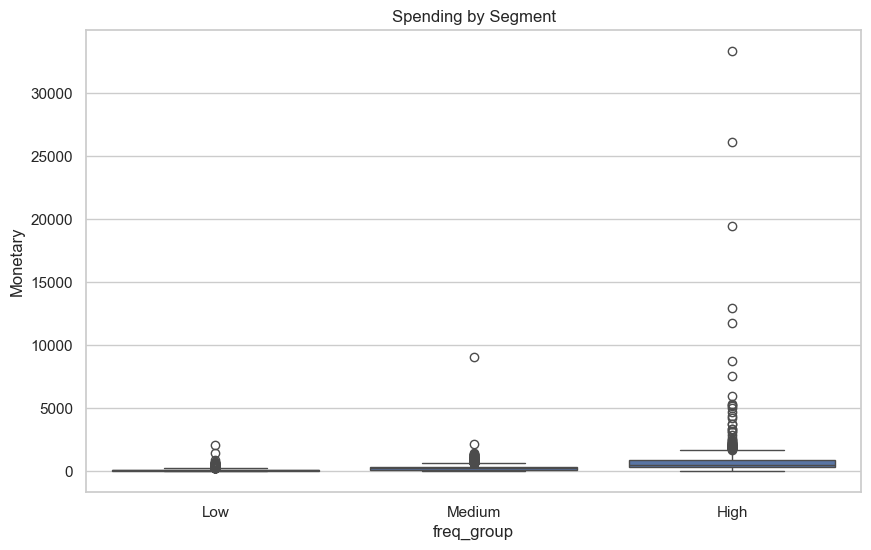

In [79]:
sns.boxplot(x='freq_group', y='Monetary', data=customer_df)
plt.title("Spending by Segment")
plt.savefig('../visualizations/13_segment_spend.png')
plt.show()
